# Курсовая работа на тему:
# "Проверка гипотезы о биномиальном распределении числа положительных изменений курса акции"

_  

# Course work on the topic:
# "Testing the hypothesis of the binomial distribution of the number of positive changes in the stock exchange rate"

Выполнил: студент группы __ПМ20-4 Савостьянов Александр Васильевич__

Performed by: student of the group __PM20-4 Savostyanov Alexander Vasilievich__

__Импортируем необходимые библиотеки__

__Import the necessary libraries__

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from scipy.stats import binom
from scipy.stats import chisquare
from scipy.special import comb
from scipy.stats import chi2
from scipy.stats import uniform
import seaborn as sns

__Загрузим датасет с данными по акции BYD, которая имеет листинг на Гонконгской бирже__

__Upload a dataset with data on a BYD stock that is listed on the Hong Kong Stock Exchange__

In [62]:
df_BYD = pd.read_csv("BYD_HKEX.csv", delimiter = ";")
df_BYD.head()

,Date,Bid,Ask,Open,Min,Max,Last,Vol
0,31.12.2021,266.6,267.0,272.0,266.6,272.0,266.6,632570000
1,30.12.2021,262.6,263.0,262.2,259.4,266.8,263.0,751460000
2,29.12.2021,262.0,262.2,259.6,256.0,263.2,262.2,616670000
3,28.12.2021,259.8,260.0,263.6,254.6,263.6,259.8,1040000000
4,24.12.2021,262.0,262.2,270.8,258.4,271.4,262.2,537940000


__Выведем график, который показывает котировки акции BYD за последние 10 лет__

__Let's output a graph that shows BYD stock quotes over the past 10 years__

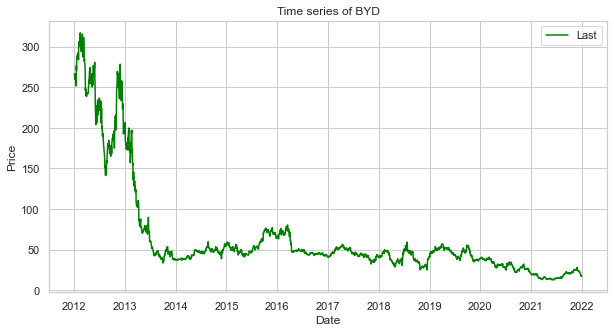

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df_draw = df_BYD[["Date", "Last"]][::-1]
df_draw["Date"] = pd.to_datetime(df_draw["Date"], format='%d.%m.%Y')
df_draw.set_index("Date", inplace=True)
df_draw["Last"] = df_draw["Last"].values[::-1]

ax.plot(df_draw["Last"], c="green", label="Last")

ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Time series of BYD")

plt.show()

__Посчитаем сколько дней каждая акция торговалась в каждом году__

__Let's count how many days each stock was traded in each year__

In [64]:
tick = ["Bank-of-China_HKEX", "BYD_HKEX", "Lenovo_HKEX", "PetroChina_HKEX", 
        "China-Evergrande_HKEX", "China-life-insurance_HKEX", "Ping-an-insurance_HKEX"]

years = list(range(2012, 2022))
df_N_Days = pd.DataFrame()
df_N_Days['Tикер'] = tick



for y in years:
    N_of_year_Days = []
    
    for t in tick:
        df = pd.read_csv(t + '.csv', delimiter = ';')
        
        amount = (pd.to_datetime(df["Date"], format='%d.%m.%Y')
                  >= pd.to_datetime(str(y) + '-01-01')) & (pd.to_datetime(df["Date"], format='%d.%m.%Y') 
                                                           < pd.to_datetime(str(y + 1) + '-01-01'))
        
        N_of_year_Days.append(len(df[amount]))
        
    df_N_Days[str(y)] = N_of_year_Days

    
    
df_N_Days

,Tикер,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Bank-of-China_HKEX,235,241,247,246,239,246,246,242,239,240
1,BYD_HKEX,247,244,247,238,238,246,246,242,239,240
2,Lenovo_HKEX,236,241,246,246,235,246,246,242,239,241
3,PetroChina_HKEX,235,240,247,246,238,246,246,241,239,241
4,China-Evergrande_HKEX,236,241,247,245,238,246,246,242,239,231
5,China-life-insurance_HKEX,235,240,247,246,237,246,246,242,239,241
6,Ping-an-insurance_HKEX,234,241,246,246,239,246,246,241,239,241


* Мы видим, что все компании-эмитенты на протяжении 10-ти лет торговались в среднем 240 дней. Можно сделать вывод, что в среднем каждая компания торговалась 5 дней в неделю, что является хорошим показателем. 

__Найдем максимальные отклонения вниз и вверх (в процентном соотношении) по ценам всех компаний за каждый год__

__Find the maximum deviations down and up (as a percentage) at the prices of all companies for each year__

In [65]:
def max_otkl(y,file):
    df = pd.read_csv(file, delimiter = ';')
    
    list_of_years = [ int(str(df['Date'][i])[6:]) for i in range(len(df['Date'])) ]
    
    df['Date'] = list_of_years
    
    N_of_days = list(np.where(df['Date'] == y)[0])[:-1]
    
    percent_list = [round((df['Last'][i+1]-df['Last'][i])/df['Last'][i] * 100, 2) for i in N_of_days ]
    
    return max(percent_list)



def min_otkl(y,file):
    df = pd.read_csv(file, delimiter = ';')
    
    list_of_years = [ int(str(df['Date'][i])[6:]) for i in range(len(df['Date'])) ]
    
    df['Date'] = list_of_years
    
    N_of_days = list(np.where(df['Date'] == y)[0])[:-1]
    
    percent_list = [round(df['Last'][i+1]/df['Last'][i]*100-100, 2 ) for i in N_of_days ]
    
    return min(percent_list)

__Максимальные отклонения вверх__

__Maximum upward deviations__

In [66]:
tick = ["Bank-of-China_HKEX", "BYD_HKEX", "Lenovo_HKEX", "PetroChina_HKEX", "China-Evergrande_HKEX", 
        "China-life-insurance_HKEX", "Ping-an-insurance_HKEX"]

years = range(2012,2022)
df_Max = pd.DataFrame()
df_Max['Тикер'] = tick



for y in years:
    max_Changes = []
    
    for t in tick:
        max_Changes.append(max_otkl(y, t + '.csv'))
        
    df_Max[str(y)] = max_Changes

    
    
df_Max

,Тикер,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Bank-of-China_HKEX,6.05,8.31,6.61,7.59,8.08,5.43,6.41,7.83,8.97,8.22
1,BYD_HKEX,10.96,13.36,40.52,13.98,11.17,7.49,11.78,23.74,17.52,11.36
2,Lenovo_HKEX,12.39,6.46,19.62,10.00,11.04,7.17,17.79,6.38,6.70,15.47
3,PetroChina_HKEX,4.05,4.26,4.73,6.33,6.78,3.24,6.20,25.44,10.66,7.08
4,China-Evergrande_HKEX,13.13,9.28,19.34,37.30,8.64,13.33,15.49,6.24,20.42,24.31
5,China-life-insurance_HKEX,6.24,4.06,5.57,8.90,6.94,4.55,7.14,6.44,7.25,6.52
6,Ping-an-insurance_HKEX,4.64,4.85,6.78,9.20,5.79,4.38,6.34,5.01,4.50,11.78


__Максимальные отклонения вниз__

__Maximum downward deviations__

In [67]:
tick = ["Bank-of-China_HKEX", "BYD_HKEX", "Lenovo_HKEX", "PetroChina_HKEX", "China-Evergrande_HKEX", 
        "China-life-insurance_HKEX", "Ping-an-insurance_HKEX"]

years = range(2012,2022)
df_Min = pd.DataFrame() 
df_Min['Тикер'] = tick



for y in years: 
    min_Changes = []
    
    for t in tick:
        min_Changes.append(min_otkl(y, t + '.csv'))
        
    df_Min[str(y)] = min_Changes

    
    
df_Min

,Тикер,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Bank-of-China_HKEX,-3.95,-3.67,-4.86,-7.71,-4.02,-4.70,-4.38,-3.52,-6.19,-3.93
1,BYD_HKEX,-9.61,-10.83,-12.41,-11.50,-6.38,-11.25,-8.40,-18.42,-13.92,-8.66
2,Lenovo_HKEX,-6.78,-8.51,-5.53,-8.18,-7.06,-4.90,-6.99,-10.64,-8.95,-10.99
3,PetroChina_HKEX,-3.24,-5.93,-6.59,-8.44,-7.52,-4.02,-6.06,-20.75,-8.82,-11.64
4,China-Evergrande_HKEX,-8.39,-4.96,-4.52,-16.15,-7.58,-18.55,-17.46,-6.05,-17.10,-14.98
5,China-life-insurance_HKEX,-7.05,-7.79,-7.88,-9.24,-4.77,-6.96,-6.09,-6.40,-12.56,-6.48
6,Ping-an-insurance_HKEX,-7.23,-8.72,-7.07,-6.20,-6.28,-8.12,-5.19,-4.88,-5.86,-7.01


* Мы видим, что в обоих случаях максимальные отклонения не превышали 50% , а значит у нас нет выбросов, которые могут повлиять на наше исследование

* We see that in both cases the maximum deviations did not exceed 50%, which means we have no outliers that can affect our research

### Выполним проверку гипотезы хи-квадрат на модельных данных

### Let's test the chi-square hypothesis on model data

Осуществим проверку при помощи выборки размером `num_of_obs` = 250 (количество рабочих дней на бирже в году) с параметрами: `n` = 5 (недельный интервал), с вероятностью `p` = 0.5; на основе биномиального распределения. В результате получаем таблицу по каждой компании в каждом году с `p-значениями`, которые были получены при помощи критерия `хи-квадрат`. Выполним расчет статистики и проведем проверку равномерности `p-значений` полученных при помощи критерия хи квадрат, на основе критерия `Колмогорова`.

Let's check hypothesis using a sample size of `num_of_obs` = 250 (the number of working days on the exchange per year) with the parameters: `n` = 5 (weekly interval), with a probability of `p` = 0.5; based on the binomial distribution. As a result, we get a table for each company in each year with `p-values` that were obtained using the `chi-square` criterion. Let's calculate the statistics and check the uniformity of the `p-values` obtained using the chi-square criterion, based on the `Kolmogorov` criterion.

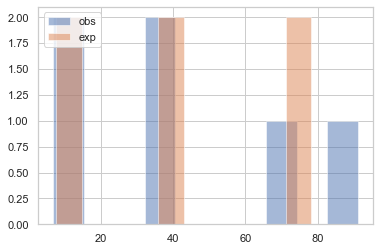

In [68]:
n = 5
p = .5
num_of_obs = 250
X = binom(n=n, p=p).rvs(size=num_of_obs)



def observed(X, n):
    X = np.array(X)
    res = []
    
    for i in range(n+1):
        res.append(sum(X==i))
        
    return np.array(res)



def expected(n, p, num_of_obs=num_of_obs):
    return np.array([binom(n=n, p=p).pmf(x) for x in range(n+1)]) * num_of_obs



obs = observed(X, 5)
exp = expected(5, 0.5)

plt.hist(np.transpose(obs), alpha = 0.5, label='obs') # Построение гистограммы
plt.hist(np.transpose(exp), alpha = 0.5, label='exp')
plt.legend(loc='upper left')
plt.show()

* Выше представлена гистограмма распределения числа скачков. Столбцы обозначают наблюдаемое количество недель с данным количеством скачков. Можем сделать вывод, что значения ожидаемых событий в большинстве случаев соответствуют значениям наблюдаемых событий.

* The histogram of the distribution of the number of jumps is shown above. The columns indicate the observed number of weeks with a expected number of jumps. We can conclude that the values of expected events in most cases correspond to the values of observed events.

__Таблица с `p-значениями` по каждой компании в каждом году, которые были получены при помощи критерия `хи-квадрат`__

__Table with `p-values` for each company in each year, which were obtained using the 'chi-square` criterion`__

In [69]:
n = 5
p = .5
num_of_obs = 250
companies = 7
years = 10
y = []



for _ in range(years):
    comp = []
    
    for __ in range(companies):
        X = binom(n=n, p=p).rvs(size=num_of_obs)
        X = np.array(X)
        obs = []
        
        for i in range(n+1):
            obs.append(sum(X==i))
            
        obs = np.array(obs)
        
        exp = np.array([binom(n=n, p=p).pmf(x) for x in range(n+1)]) * num_of_obs
        
        comp.append(chisquare(obs, exp)[1])
        
    y.append(comp)
  
    
    
y = np.array(y)
np.transpose(y)

years_ = [str(i) for i in range(2012, 2022)]

df_p_val = pd.DataFrame()
for index, year in enumerate(years_):
    df_p_val[year] = y[index]
    

    
y_2012 = list(df_p_val["2012"])

df_p_val

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.479562,0.126195,0.078755,0.146133,0.140900,0.149490,0.036538,0.291559,0.431500,0.565651
1,0.457621,0.178112,0.251995,0.984968,0.051032,0.746485,0.760149,0.230459,0.092201,0.863985
2,0.982214,0.385258,0.767918,0.536134,0.162152,0.718973,0.126195,0.707139,0.715030,0.541611
3,0.338612,0.279774,0.626658,0.528875,0.578791,0.074334,0.657886,0.311233,0.642228,0.457621
4,0.289171,0.433104,0.216041,0.804267,0.255204,0.289171,0.796704,0.663776,0.098986,0.472744
5,0.909254,0.420388,0.066498,0.146133,0.306219,0.414125,0.349512,0.528875,0.086669,0.277464
6,0.465985,0.326660,0.433104,0.307466,0.789089,0.981488,0.961918,0.078755,0.580679,0.338612


__Осуществим проверку критерия на основе критерия `Колмогорова`__

__Let's check the criterion based on the `Kolmogorov` criterion__

In [70]:
def uniformTest(X, alpha=.1, debug=False):
    X = np.array(sorted(X))
    n = len(X)

    a, b = 0, 1

    F = uniform(a, b-a).cdf

    D_upper = max([i/n - F(X[i-1]) for i in range(1, len(X)+1)])
    D_lower = max([F(X[i-1]) - (i-1)/n for i in range(1, len(X)+1)])

    D = max(D_upper, D_lower)

    lam = (6*n * D + 1)/(6 * n**.5)

    crit_values = {0.15: 1.1379, 0.1: 1.2238, 0.05: 1.3581, 0.025: 1.4802, 0.01: 1.6276} if len(X) > 20\
           else {0.1: 0.835, 0.05: 0.909, 0.01: 1.057}

    assert alpha in crit_values, "В таблице значений нет такой верхней проентной точки!"

    crit_lam = crit_values[alpha]

    if debug:
        print(lam, crit_lam, sep='\n')

    return lam <= crit_lam



print(uniformTest(y_2012))

True


* Действительно выборка соответствует критерию `Колмогорова`

* Indeed, the sample meets `Kolmogorov's` criterion

__Построим гистограмму `p_values` за 2012 год__

__Let's create a histogram of `p_values` for 2012__

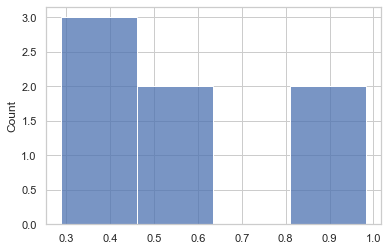

In [71]:
sns_plot = sns.histplot(y_2012)
fig = sns_plot.get_figure()
plt.show()

### Выполним проверку гипотезы `хи-квадрат` на реальных данных

### Let's test the `chi-square` hypothesis on real data

Перейдем к проверке гипотезы `хи-квадрат` о биномиальном распределении на эмпирических данных (данные по 7 компаниям, представленным выше, за 10 лет) с параметрами: `n` = 5 (недельный интервал), с вероятностью `p` = 0.5. В результате получаем таблицу с `p-значениями` для каждой компании в каждом году, которые были получены при помощи критерия `хи-квадрат`. Проведем проверку равномерности `p-значений` на основе критерия `Колмогорова`.

Let's move on to testing the `chi-square` hypothesis about binomial distribution based on empirical data (data for 7 companies presented above for 10 years) with parameters: `n` = 5 (weekly interval), with probability `p` = 0.5. As a result, we get a table with `p-values` for each company in each year that were obtained using the chi-square criterion. We will check the uniformity of the `p-values` based on the `Kolmogorov` criterion.

__Функция поиска частоты событий, когда были положительные скачки на недельном интервале__

__Function to search for the frequency of events when there were positive jumps in the weekly interval__

In [72]:
tickers = ["Bank-of-China_HKEX", "BYD_HKEX", "Lenovo_HKEX", "PetroChina_HKEX", "China-Evergrande_HKEX", 
           "China-life-insurance_HKEX", "Ping-an-insurance_HKEX"]

years = list(range(2012, 2022))
ALL_S = {ticker: [] for ticker in tickers}



for ticker in tickers:
    df = pd.read_csv(f'{ticker}.csv', delimiter=';')  
    n = 50
    S = [[0]*n for _ in range(len(years))]

    for year_number, year in enumerate(years):
        current_year_close = []

        for index, row in enumerate(df["Date"]):
            if str(row)[-4:] == str(year):
                current_year_close.append(df['Last'][index])

        diff_array = []
        for i in range(1, len(current_year_close)):
            diff_array.append(current_year_close[i]-current_year_close[i-1])

        diff_array = [diff_array[i*5:(i+1)*5] for i in range(0, 50)]

        count_per_week = []  

        for week in diff_array:
            count = 0
            
            for day in range(len(week)):
                if week[day]-week[day-1] > 0:
                    count += 1

            count_per_week.append(count)

        S[year_number] = count_per_week
        
    ALL_S[ticker] = S

__Таблица с `p-значениями` по каждой компании (эмпирические данные) в каждом году, которые были получены при помощи критерия `хи-квадрат`__

__Table with `p-values` for each company (empirical data) in each year, which were obtained using the `chi-square` criterion__

In [73]:
n = 5
p = 0.5
num_of_obs = 50
companies = 6
y = []



for year in range(len(years)):
    comp = []
    
    for company in ALL_S.keys():
        X = ALL_S[company][year]
        X = np.array(X)
        obs = []
        
        for i in range(n):
            obs.append(sum([1 for el in X if el==i]))
            
        obs = np.array(obs)
        
        exp = np.array([binom(n=n, p=p).pmf(x) for x in range(n)]) * num_of_obs
        
        comp.append(chisquare(obs, exp)[1])
        
    y.append(comp)


years_ = [str(year) for year in range(2012, 2022)]

df = pd.DataFrame()
for index, year in enumerate(years_):
    df[year] = y[index]
    

y_2012 = list(df["2012"])



df

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000242,0.000564,0.001949,0.001267,0.001231,6.199563e-07,0.000344,0.000075,0.013606,1.403746e-07
1,0.004203,0.004324,0.010314,0.006978,0.008487,1.005559e-01,0.068339,0.114137,0.004841,2.151228e-04
2,0.001267,0.000003,0.001506,0.012875,0.001595,1.060470e-02,0.010314,0.006237,0.003972,1.949013e-03
3,0.000487,0.007380,0.002185,0.226563,0.001789,1.505638e-03,0.007805,0.013235,0.038238,1.323544e-02
4,0.001267,0.003972,0.003077,0.000334,0.031693,1.381246e-03,0.022905,0.048579,0.018411,5.896384e-03
5,0.000502,0.014780,0.003447,0.064867,0.003077,1.036178e-06,0.002746,0.006978,0.013235,6.237283e-03
6,0.000197,0.001381,0.004841,0.001595,0.013235,3.447011e-03,0.000306,0.000191,0.081926,2.265626e-01


__Осуществим проверку критерия на основе критерия `Колмогорова`__

__Let's check the criterion based on the `Kolmogorov` criterion__

In [74]:
def uniformTest(X, alpha=.1, debug=False):
    X = np.array(sorted(X))
    n = len(X)

    a, b = 0, 1

    F = uniform(a, b-a).cdf

    D_upper = max([i/n - F(X[i-1]) for i in range(1, len(X)+1)])
    D_lower = max([F(X[i-1]) - (i-1)/n for i in range(1, len(X)+1)])

    D = max(D_upper, D_lower)

    lam = (6*n * D + 1)/(6 * n**.5)

    crit_values = {0.15: 1.1379, 0.1: 1.2238, 0.05: 1.3581, 0.025: 1.4802, 0.01: 1.6276} if len(X) > 20\
           else {0.1: 0.835, 0.05: 0.909, 0.01: 1.057}

    assert alpha in crit_values, "В таблице значений нет такой верхней проентной точки!"

    crit_lam = crit_values[alpha]

    if debug:
        print(lam, crit_lam, sep='\n')

    return lam <= crit_lam



print(uniformTest(y_2012))

False


* Выборка не соответствует критерию `Колмогорова`

* The sample does not meet `Kolmogorov's` criterion

__Построим гистограмму `p_values` за 2012 год__

__Let's create a histogram of `p_values` for 2012__

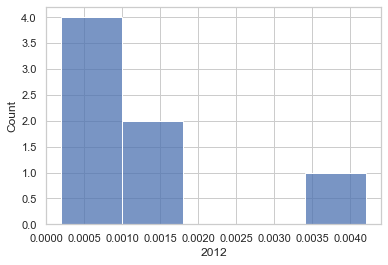

In [75]:
sns_plot = sns.histplot(df["2012"])
fig = sns_plot.get_figure()

### Выводы

### Conclusions

По итогу можно сказать, что аномалии в ценах и количестве торговых дней акций выявлено не было. Было выявлено, что модельные данные действительно равномерно распределены (была осуществлена проверка с помощью критерия Колмогорова), чего нельзя сказать о реальных данных, которые не распределены равномерно (была осуществлена проверка с помощью критерия Колмогорова).

Из этого можно сделать вывод, что гипотеза не принимается и, что количество положительных скачков цены курса акции не распределено по биномиальному закону. 

As a result, we can say that there were no anomalies in prices and the number of trading days of the promotion. It was revealed that the model data are indeed evenly distributed (verification was carried out using the Kolmogorov criterion), which cannot be said about real data that are not evenly distributed (verification was carried out using the Kolmogorov criterion).

From this it can be concluded that the hypothesis is not accepted and that the number of positive jumps in the stock price is not distributed according to the binomial law.